In [1]:
from simulation import simulate_lineage
import numpy as np
import sys
#sys.path.append('../lateral')
%load_ext autoreload
%autoreload 2

In [5]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
cassette_sites = slow_guides+medium_guides
lineage, Q = simulate_lineage(cassette_sites=cassette_sites, num_init_cells=2, init_death_prob=0.1,
                     init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=10)

from conversion_utils import networkx_to_ete, get_ete_cm
etetree = networkx_to_ete(lineage)
cm = get_ete_cm(etetree)
cm

,0,1,2,3,4,5
name,,,,,,
00,0,1,2,3,4,5
0100000,0,1,2,3,4,57
0100100,0,1,2,3,4,57
0100110000,0,1,2,3,4,57
01001100010,0,1,2,3,4,57
...,...,...,...,...,...,...
1001111100,0,234,2,51,78,5
10011111010,0,234,2,51,78,5
10011111011,0,234,2,51,78,5


In [6]:
true_names = cm.index
new_names = np.arange(0, len(cm.index))
cm.index = new_names
cm

,0,1,2,3,4,5
0,0,1,2,3,4,5
1,0,1,2,3,4,57
2,0,1,2,3,4,57
3,0,1,2,3,4,57
4,0,1,2,3,4,57
...,...,...,...,...,...,...
81,0,234,2,51,78,5
82,0,234,2,51,78,5
83,0,234,2,51,78,5
84,0,1,2,51,78,5


In [7]:
from scipy.optimize import minimize

def get_ancestors(lca):
    ancestors = [lca]
    for ancestor in ancestors:
        for i in range(len(ancestor)):
            if ancestor[i] != i:
                new_ancestor = ancestor.copy()
                new_ancestor[i] = i
                ancestors += [new_ancestor]
        ancestors = list(np.unique(np.array(ancestors), axis=0))
    
    return ancestors

from scipy.linalg import expm
def P(t,Q):
    return expm(Q*t)

from math import exp, log
def rates_to_prob(rates, t):
    logprob = 0
    for rate in rates:
        if rate<=0: logprob += -(-rate) * t
        else: logprob += log(1-exp(-rate * t))
    return logprob

#TODO: figure out how to add the probabilities in log space in a numerically stable way
# right now non-LCA ancestors are not being taken into account
def l(t, x, y, ancestors, Q, a_prior=None):
    #Pt = P(t,Q)
    logprob = 0
    OVERFLOW_DIST = 10000
    #print(t)
    lca = ancestors[0]
    logprobs = []
    for ancestor in ancestors:
        prior_prob = a_prior[np.sum(lca!=ancestor)] if a_prior is not None else 1
        #print(t)
        x_logprob = rates_to_prob(Q[ancestor,x],t)
        y_logprob = rates_to_prob(Q[ancestor,y],t)
        #print(x_logprob+y_logprob)
        to_add = x_logprob+y_logprob+log(prior_prob)
        #print(to_add)
        logprobs.append(to_add)
    logprobs = np.array(logprobs)
    #normalizer = min(logprobs)
    #logprobs -= normalizer
    #print(logprobs)
    return -logprobs[0]

def get_dist_est(Q, x, y, all_a=True, a_prior=None):
    
    n_sites = len(x)
    lca = (x!=y) * np.arange(n_sites) + (x==y) * x
    ancestors=[lca]
    if all_a: ancestors = get_ancestors(lca)
    
    return minimize(l, 0.0002, args=(x,y,ancestors,Q,a_prior), bounds=[(0.0001,1000)], method='Powell').x[0]
# x_seq = cm_np[2,:]
# y_seq = cm_np[3,:]
# print(x_seq)
# print(y_seq)
# print(get_dist_est(Q,x_seq,y_seq))

In [8]:
from tqdm.notebook import tqdm
def get_dm(cm_np, Q, all_a = True, a_prior=None):
    
    n_species = len(cm_np[:,0])
    dm = np.zeros((n_species,n_species))
    for x in tqdm(range(n_species), leave=False):
        for y in tqdm(range(n_species),leave=False):
            x_seq = cm_np[x,:]
            y_seq = cm_np[y,:]
            if x == y or (x_seq==y_seq).all():
                dm[x,y]=0
            else: dm[x,y]=get_dist_est(Q,x_seq,y_seq,all_a=all_a)#dm[x,y]=1#
    return dm

In [10]:
cm_np = cm.to_numpy()
dm1 = get_dm(cm_np, Q, all_a = False)
# dm2 = get_dm(cm_np, Q, all_a = True) #TODO: ancestor calculations not actually implemented yet

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

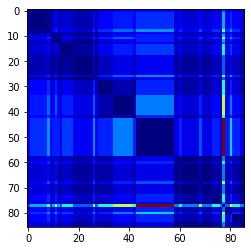

In [11]:
import matplotlib.pyplot as plt
plt.imshow(dm1, cmap='jet', interpolation='nearest')
plt.show()
# plt.imshow(dm2, cmap='jet', interpolation='nearest')
# plt.show()

In [13]:
n_species = cm_np.shape[0]
print(cm_np[np.argmax(dm1) % n_species,:])
print(cm_np[int(np.argmax(dm1) / n_species),:])

[ 31  38 192  51  78  51]
[ 7  1  2 51 78 56]


In [14]:
def get_phylip_dm(dm, names):
#names = cm.index
    line1 = '%d' % len(names)
    lines = [line1]
    for name, row in zip(names, dm):
        line = ""
        line += str(name)
        line += '\t'
        line += ' '.join([str(dist) for dist in row])
        lines.append(line)
        #for value in row:
        #    dm_phylip += '\t%s' % value
    return '\n'.join(lines)

In [15]:
from ete3 import Tree
import os
import subprocess
def weighbor(pdm, names, seq_len):
    dm_phylip = get_phylip_dm(pdm, names)
    #print(dm_phylip)
    cmd = os.path.expanduser('~/phylogeny/Weighbor/weighbor')
    args = ('-L %i -b 300' % seq_len).split(' ') #todo: double-check Weighbor parameters
    proc = subprocess.run([cmd] + args,
                          input=dm_phylip.encode(),
                          stdout=subprocess.PIPE)
    newick = proc.stdout.decode().strip()
    #print(newick)
    return Tree(newick)

In [16]:
def est_Q(inferred_tree, cm_np):
    for node in inferred_tree.get_leaves():
        #print(node.name)
        node.cassette_state = cm_np[int(node.name),:]
        #print(node.cassette_state)
    num_states = np.max(cm_np)+1
    transition_counter = np.zeros((num_states,num_states))
    state_counter = np.zeros(num_states)
    #print(transition_counter)
    n_sites = None
    for node in inferred_tree.traverse("postorder"):
        if not hasattr(node,'cassette_state'):
            #todo: lca of multiple children
            x = node.children[0].cassette_state
            y = node.children[1].cassette_state
            n_sites = len(x)
            lca = (x!=y) * np.arange(n_sites) + (x==y) * x
            node.cassette_state = lca
        n_sites = len(node.cassette_state)
        if len(node.children)>0:
            state_counter[node.cassette_state] += 1
        for child in node.children:
            for k in range(n_sites):
                from_state = node.cassette_state[k]
                to_state = child.cassette_state[k]
    #                 print(from_state,to_state)
                transition_counter[from_state,to_state] += 1
    
    EPSILON = 0.001
    Q_est = transition_counter/(state_counter[:,None]+EPSILON)
    np.fill_diagonal(Q_est,np.diag(Q_est)*-1)
    return Q_est

In [18]:
#estimate a prior over ancestors based on how many differences they have from the LCA
#for each pair of nodes in the inferred tree
def est_a_prior(tree):
    n_sites = len(tree.get_leaves()[0].cassette_state)
    a_prior = np.zeros(n_sites)
    for x in tree.get_leaves():
        for y in tree.get_leaves():
            x_seq = x.cassette_state
            y_seq = y.cassette_state
            #print('-------')
            lca = (x_seq!=y_seq) * np.arange(n_sites) + (x_seq==y_seq) * x_seq
            a_seq = tree.get_common_ancestor(x,y).cassette_state
            num_diffs = np.sum(lca!=a_seq)
            a_prior[num_diffs] += 1
    return a_prior/np.sum(a_prior)
            

In [19]:
Q_ests = []
trees = []
def infer_tree(cm, Q=None):
    true_names = cm.index
    new_names = np.arange(0, len(cm.index))
    cm.index = new_names
    
    #set initial rate matrix
    num_states = np.max(cm.to_numpy())+1
    num_sites = len(cassette_sites)
    Q0 = np.zeros((num_states, num_states))
    Q0[0:num_sites,num_sites:num_states]=1
    np.fill_diagonal(Q0, -(num_states-num_sites))
    
    if Q is not None: Q0=Q
    
    Q_est = Q0
    Q_ests.append(Q_est)
    for i in tqdm(range(2)):
        
        #compute distance matrix
        print('computing distance matrix')
        cm_np = cm.to_numpy()
        dm = get_dm(cm_np, Q0, all_a=False)

        #infer using Weighbor
        print('using Weighbor to infer tree')
        names = cm.index
        inferred_tree = weighbor(dm, names, 6)
        trees.append(inferred_tree)
        
        #estimate Q and the prior on the ancestors
        print('getting new estimate of Q')
        Q_est = est_Q(inferred_tree, cm_np)
        a_prior = est_a_prior(inferred_tree)
        Q_ests.append(Q_est)

In [20]:
infer_tree(cm,Q)

  0%|          | 0/2 [00:00<?, ?it/s]

computing distance matrix


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

using Weighbor to infer tree
getting new estimate of Q
computing distance matrix


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

using Weighbor to infer tree
getting new estimate of Q


In [21]:
np.max(Q_ests[1]-Q_ests[2])

0.0

In [22]:
print(trees[0].get_ascii())
print(trees[1].get_ascii())


         /-42
        |
        |      /-41
        |   /-|
        |  |  |   /-40
      /-|  |   \-|
     |  |  |     |   /-39
     |  |  |      \-|
     |  |  |        |   /-38
     |  |  |         \-|
     |  |  |           |   /-37
     |   \-|            \-|
     |     |              |   /-36
     |     |               \-|
     |     |                 |   /-35
     |     |                  \-|
     |     |                     \-34
     |     |
     |     |   /-33
     |      \-|
     |        |   /-32
     |         \-|
     |           |   /-31
     |            \-|
   /-|              |   /-30
  |  |               \-|
  |  |                 |   /-29
  |  |                  \-|
  |  |                     \-28
  |  |
  |  |         /-77
  |  |      /-|
  |  |     |   \-78
  |  |   /-|
  |  |  |  |   /-79
  |  |  |   \-|
  |  |  |      \-80
  |  |  |
  |  |  |      /-74
  |  |  |   /-|
  |  |  |  |  |   /-73
  |  |  |  |   \-|
  |  |  |  |      \-75
  |   \-|  |
  |     |  |      

In [23]:
print(etetree.get_ascii())


       /-00
      |
      |          /01000010000-0100000
      |         |
      |   /0100100    /010010-0100100
    /0|  |      |    |
   |  |  |      |    |                              /-0100110000
   |  |  |       \01001                    /010011000
   |  |  |           |                    |        |          /-01001100010
   |  |  |           |                    |         \0100110001
   |  |  |            \010011010011001001100                  \-01001100011
   |   \01                                |
   |     |                                |                   /-01001100100
   |     |                                |         /0100110010
   |     |                                 \010011001         \-01001100101
   |     |                                         |
   |     |                                          \-0100110011
   |     |
   |      \-011
   |
   |                                                          /-10000000000
   |                                     

In [24]:
name_dict = dict(zip(new_names,true_names))
#name_dict

In [25]:
tree = trees[1]
for node in tree.traverse('postorder'):
    if node.name != '':
        node.name = name_dict[int(node.name)]

In [26]:
print(tree.get_ascii())


         /-1001001
        |
        |      /-10010001111
        |   /-|
        |  |  |   /-10010001110
      /-|  |   \-|
     |  |  |     |   /-10010001101
     |  |  |      \-|
     |  |  |        |   /-10010001100
     |  |  |         \-|
     |  |  |           |   /-10010001011
     |   \-|            \-|
     |     |              |   /-10010001010
     |     |               \-|
     |     |                 |   /-10010001001
     |     |                  \-|
     |     |                     \-10010001000
     |     |
     |     |   /-10010000101
     |      \-|
     |        |   /-10010000100
     |         \-|
     |           |   /-10010000011
     |            \-|
   /-|              |   /-10010000010
  |  |               \-|
  |  |                 |   /-10010000001
  |  |                  \-|
  |  |                     \-10010000000
  |  |
  |  |         /-10011110000
  |  |      /-|
  |  |     |   \-10011110010
  |  |   /-|
  |  |  |  |   /-10011110011
  |  |  |   \-|
  | 